<a href="https://colab.research.google.com/github/mariafernandasf/ml4fg-final-project/blob/main/%5Bms7073%5D_ML4F4_Interim_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import sparse
import torch
import torch.nn as nn
import torch.utils.data
assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)

Torch version: 2.8.0+cu126


In [ ]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import annotations
import os
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import gzip
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Data PreProcessing

### Load Datasets

In [ ]:
DATA_DIR = Path("/content/drive/My Drive/ML for functional genomics/COVID_single_cell/")

In [ ]:
CELL_META_PATH = DATA_DIR / "GSE158055_cell_annotation.csv.gz"
SAMPLE_META_PATH = DATA_DIR / "GSE158055_sample_metadata.tsv"

PC_30_PATH = DATA_DIR / "PC30.npy"
PC_300_PATH = DATA_DIR / "PC300.npy"

In [ ]:
cell_metadata = pd.read_csv(CELL_META_PATH, compression="gzip", low_memory=False)
sample_metadata = pd.read_csv(SAMPLE_META_PATH, sep="\t")
pc30_data = np.load(PC_30_PATH, mmap_mode="r")
pc300_data = np.load(PC_300_PATH, mmap_mode="r")

## Cell Metadata

### Data Cleaning

In [ ]:
cell_metadata["sampleID"] = cell_metadata["sampleID"].str.strip()
cell_metadata["cellName"] = cell_metadata["cellName"].str.strip()

### Data Exploration

In [ ]:
print("CELL METADATA:")
print("\nCell Metadata Columns: ", cell_metadata.columns)
print("\nShape: ", cell_metadata.shape)
print("\nNumber of unique cells: ", cell_metadata.groupby("cellName").count().shape)
print("\nNumber of unique samples/individuals: ",cell_metadata.groupby("sampleID").count().shape)
print("\nUnique Cell Types: ", cell_metadata["celltype"].unique())
print("\nUnique Major Types: ", cell_metadata["majorType"].unique())
print("\nCellNames: ", cell_metadata["cellName"].head())
print("\nsampleID: ", cell_metadata["sampleID"].head())

print(cell_metadata.dtypes)

CELL METADATA:

Cell Metadata Columns:  Index(['cellName', 'sampleID', 'celltype', 'majorType'], dtype='object')

Shape:  (1462702, 4)

Number of unique cells:  (1462702, 3)

Number of unique samples/individuals:  (284, 3)

Unique Cell Types:  ['Mono_c1-CD14-CCL3' 'B_c02-MS4A1-CD27' 'B_c01-TCL1A'
 'Mono_c2-CD14-HLA-DPB1' 'Macro_c2-CCL3L1' 'T_CD4_c03-ITGA4'
 'B_c04-SOX5-TNFRSF1B' 'Mono_c3-CD14-VCAN' 'Macro_c1-C1QC'
 'T_CD4_c04-ANXA2' 'Mono_c5-CD16' 'T_CD8_c07-TYROBP' 'T_CD8_c01-LEF1'
 'T_CD4_c01-LEF1' 'T_CD8_c08-IL2RB' 'Mono_c4-CD14-CD16' 'B_c03-CD27-AIM2'
 'NK_c01-FCGR3A' 'DC_c1-CLEC9A' 'T_CD8_c05-ZNF683' 'DC_c2-CD1C'
 'T_CD4_c12-FOXP3' 'T_CD8_c10-MKI67-GZMK' 'T_CD8_c06-TNF' 'T_CD4_c05-FOS'
 'T_CD4_c06-NR4A2' 'T_CD8_c02-GPR183' 'T_CD4_c07-AHNAK' 'T_CD4_c02-AQP3'
 'Mega' 'T_CD8_c09-SLC4A10' 'T_CD8_c03-GZMK' 'T_CD4_c13-MKI67-CCL5_l'
 'Neu_c1-IL1B' 'Neu_c2-CXCR4(low)' 'T_gdT_c14-TRDV2' 'B_c05-MZB1-XBP1'
 'T_CD4_c09-GZMK-FOS_l' 'NK_c02-NCAM1' 'T_CD4_c11-GNLY'
 'T_CD4_c08-GZMK-FOS_h' 'B_c06

## Sample Metadata

### Data Cleaning

In [ ]:
sample_metadata["characteristics: Age"] = sample_metadata["characteristics: Age"].replace('unknown', np.nan)
sample_metadata["characteristics: Sex"] = sample_metadata["characteristics: Sex"].replace('unknown', np.nan)
sample_metadata["characteristics: Comorbidities"] = sample_metadata["characteristics: Comorbidities"].replace('unknown', np.nan)
sample_metadata["characteristics: COVID-19-related medication and anti-microbials"] = sample_metadata["characteristics: COVID-19-related medication and anti-microbials"].replace('unknown', np.nan)
sample_metadata["characteristics: Leukocytes [G/L]"] = sample_metadata["characteristics: Leukocytes [G/L]"].replace('unknown', np.nan)
sample_metadata["characteristics: Neutrophils [G/L]"] = sample_metadata["characteristics: Neutrophils [G/L]"].replace('unknown', np.nan)
sample_metadata["characteristics: Lymphocytes [G/L]"] = sample_metadata["characteristics: Lymphocytes [G/L]"].replace('unknown', np.nan)

sample_metadata["characteristics: Age"] = pd.to_numeric(sample_metadata["characteristics: Age"], errors='coerce')
sample_metadata["characteristics: Sampling day (Days after symptom onset)"] = pd.to_numeric(sample_metadata["characteristics: Sampling day (Days after symptom onset)"], errors='coerce')

sample_metadata = sample_metadata.rename(columns={"characteristics:  Datasets": "characteristics: Datasets"})
sample_metadata["characteristics: Comorbidities flag"] = np.where(sample_metadata["characteristics: Comorbidities"] != "none", True, False)
sample_metadata["Sample name"] = sample_metadata["Sample name"].str.strip()
sample_metadata["title"] = sample_metadata["title"].str.strip()
sample_metadata["Patients"] = sample_metadata["Patients"].str.strip()

def map_covid_binary(x):
  if "positive" in x:
    return 1
  if "negative" in x:
    return 0
  return np.nan

def map_severity(x):
    if "control" in x:
        return 0
    if "mild/moderate" in x:
        return 1
    if "severe/critical" in x:
        return 2
    return np.nan

sample_metadata["covid flag"] = sample_metadata["characteristics: SARS-CoV-2"].map(map_covid_binary).astype("float")
sample_metadata["covid severity flag"] = sample_metadata["characteristics: CoVID-19 severity"].map(map_severity).astype("float")

### Data Exploration

In [ ]:
print("SAMPLE METADATA:")
print("Sample metadata Columns: ", sample_metadata.columns)
print("Shape: ", sample_metadata.shape)
print("Number of unique samples/individuals: ", sample_metadata.groupby("Sample name").count().shape)
print("Number of unique patients: ", sample_metadata.groupby("Patients").count().shape)
print("\nSample name: ", sample_metadata["Sample name"].head())
print("\nTitle: ", sample_metadata["title"].head())
print("\nOrganism: ", sample_metadata["organism"].unique())
print("\nPatients: ", sample_metadata["Patients"].head())
print("Sample Name == Title?", sample_metadata['Sample name'].equals(sample_metadata['title']))

print(sample_metadata.dtypes)
print("Datasets: ", sample_metadata["characteristics: Datasets"].unique())
print("City: ", sample_metadata["characteristics: City"].unique())
print("Age: ", sample_metadata["characteristics: Age"].unique())
print("Sex: ", sample_metadata["characteristics: Sex"].unique())
print("Sample Type: ", sample_metadata["characteristics: Sample type"].unique())
print("Covid-19 severity: " , sample_metadata["characteristics: CoVID-19 severity"].unique())
print("Sample time: " , sample_metadata["characteristics: Sample time"].unique())
print("Sampling day: " , sample_metadata["characteristics: Sampling day (Days after symptom onset)"].unique())
print("SARS-CoV-2: " , sample_metadata["characteristics: SARS-CoV-2"].unique())
print("Single cell sequencing platform: " , sample_metadata["characteristics: Single cell sequencing platform"].unique())
print("BCR single cell sequencing: " , sample_metadata["characteristics: BCR single cell sequencing"].unique())
print("TCR single cell sequencing: " , sample_metadata["characteristics: TCR single cell sequencing"].unique())
print("Outcome: ", sample_metadata["characteristics: Outcome"].unique())
print("Comorbidities: ", sample_metadata["characteristics: Comorbidities"].unique())
print("COVID-19-related medication and anti-microbials: ", sample_metadata["characteristics: COVID-19-related medication and anti-microbials"].unique())
print("Leukocytes [G/L]: ", sample_metadata["characteristics: Leukocytes [G/L]"].unique())
print("Neutrophils [G/L]: ", sample_metadata["characteristics: Neutrophils [G/L]"].unique())
print("Lymphocytes [G/L]: ", sample_metadata["characteristics: Lymphocytes [G/L]"].unique())
print("Unpublished: ", sample_metadata["characteristics: Unpublished"].unique())
#print("geo accession: ", sample_metadata["characteristics: geo accession"].unique())
print("instrument model: ", sample_metadata["characteristics: instrument model"].unique())
print("Comorbidities Count: ", sample_metadata["characteristics: Comorbidities flag"].value_counts())

SAMPLE METADATA:
Sample metadata Columns:  Index(['Sample name', 'title', 'organism', 'Patients',
       'characteristics: Datasets', 'characteristics: City',
       'characteristics: Age', 'characteristics: Sex',
       'characteristics: Sample type', 'characteristics: CoVID-19 severity',
       'characteristics: Sample time',
       'characteristics: Sampling day (Days after symptom onset)',
       'characteristics: SARS-CoV-2',
       'characteristics: Single cell sequencing platform',
       'characteristics: BCR single cell sequencing',
       'characteristics: TCR single cell sequencing',
       'characteristics: Outcome', 'characteristics: Comorbidities',
       'characteristics: COVID-19-related medication and anti-microbials',
       'characteristics: Leukocytes [G/L]',
       'characteristics: Neutrophils [G/L]',
       'characteristics: Lymphocytes [G/L]', 'characteristics: Unpublished',
       'characteristics: geo accession', 'characteristics: instrument model',
       'ch

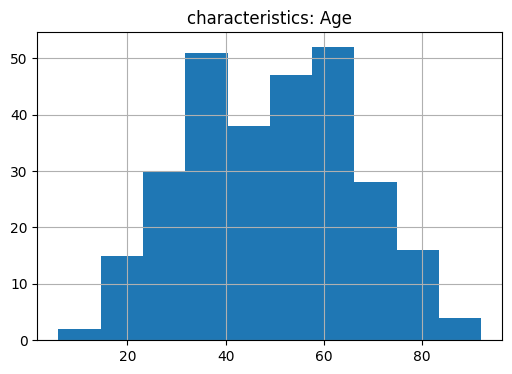

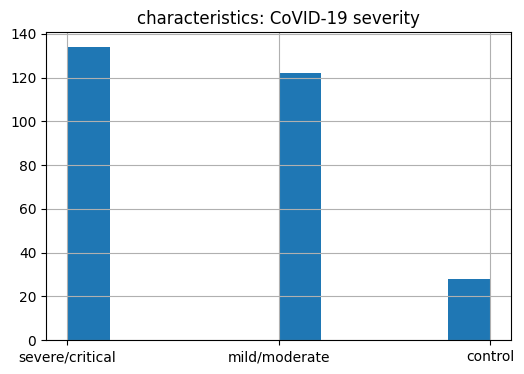

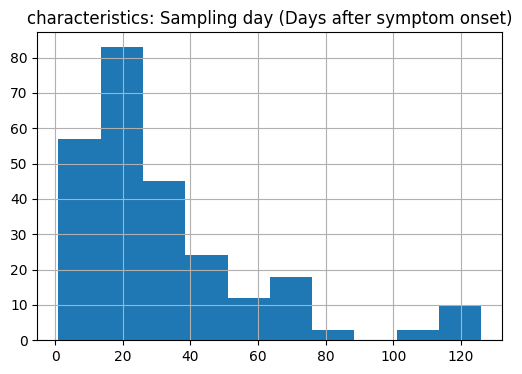

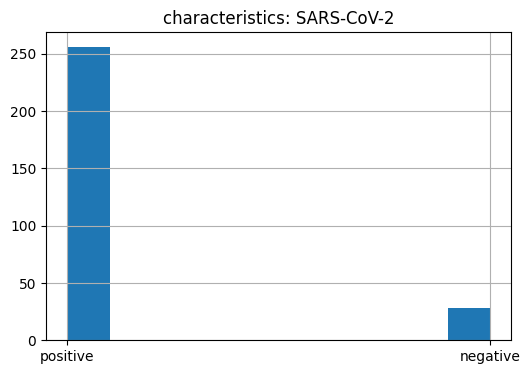

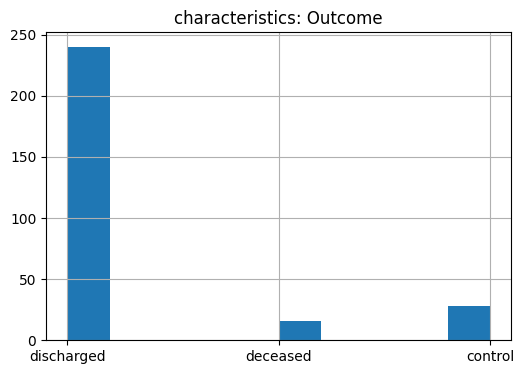

In [ ]:
subset = ["characteristics: Age","characteristics: CoVID-19 severity",
          "characteristics: Sampling day (Days after symptom onset)",
          "characteristics: SARS-CoV-2", "characteristics: Outcome",
          ]
for col in subset:
  plt.figure(figsize=(6,4))

  sample_metadata[col].hist()
  plt.title(col)
  plt.show()

/tmp/ipython-input-3051499463.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_bucket', 'characteristics: CoVID-19 severity'])
/tmp/ipython-input-3051499463.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)  # normalize within each age bucket


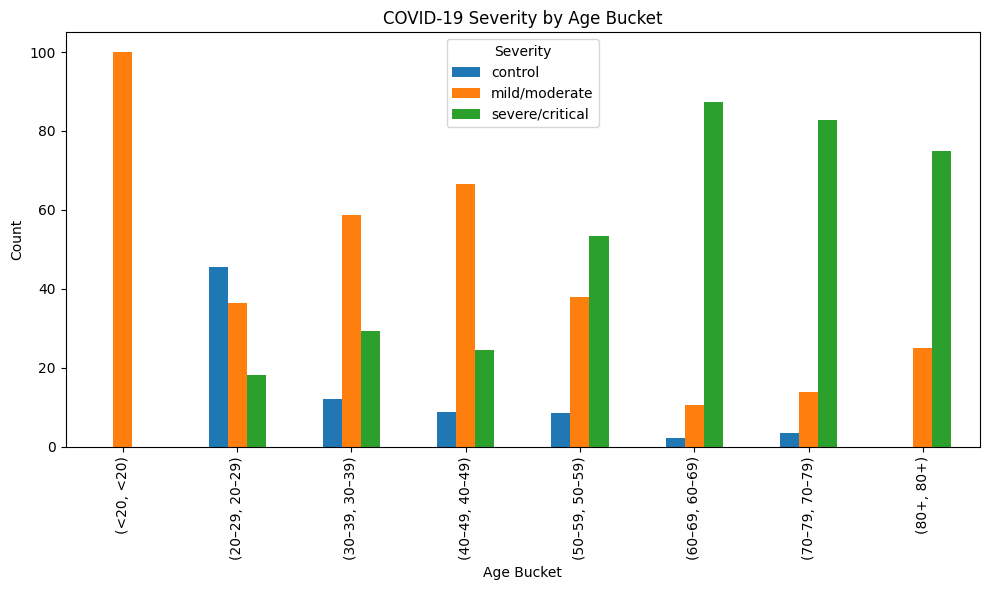

In [ ]:
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<20', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
sample_metadata['age_bucket'] = pd.cut(sample_metadata['characteristics: Age'], bins=age_bins, labels=age_labels, right=False)

pivot = (
    sample_metadata
    .groupby(['age_bucket', 'characteristics: CoVID-19 severity'])
    .size()
    .groupby(level=0)  # normalize within each age bucket
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

pivot.plot(kind='bar', figsize=(10,6))
plt.title("COVID-19 Severity by Age Bucket")
plt.xlabel("Age Bucket")
plt.ylabel("Count")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2694735728.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_bucket', 'characteristics: Outcome'])
/tmp/ipython-input-2694735728.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)  # normalize within each age bucket


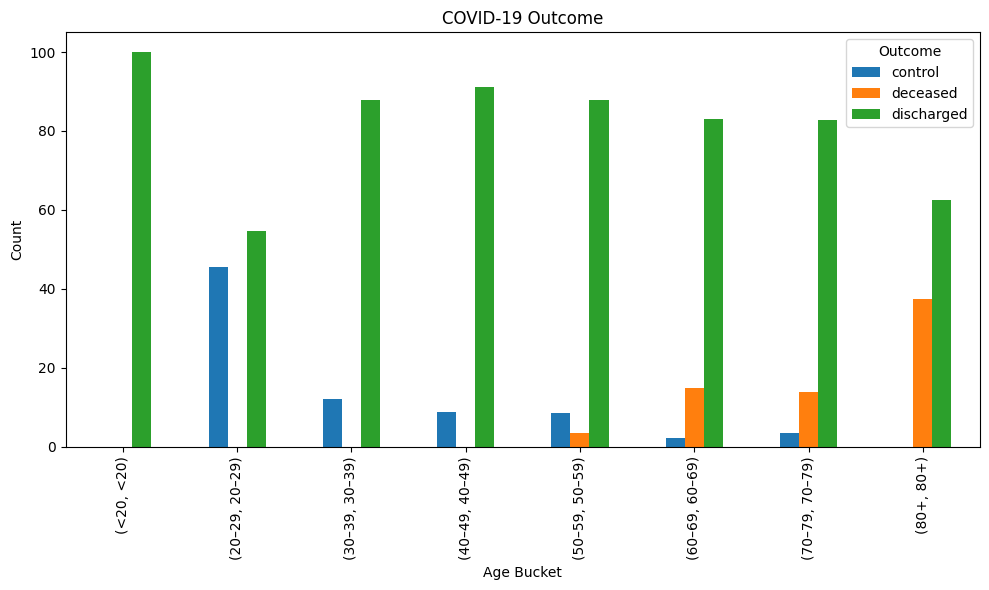

In [ ]:

pivot = (
    sample_metadata
    .groupby(['age_bucket', 'characteristics: Outcome'])
    .size()
    .groupby(level=0)  # normalize within each age bucket
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

pivot.plot(kind='bar', figsize=(10,6))
plt.title("COVID-19 Outcome")
plt.xlabel("Age Bucket")
plt.ylabel("Count")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

## PC30 and PC300

In [ ]:
print("PCA 30:")
print("Type: ", type(pc30_data))
print("Shape: ", pc30_data.shape)
print("Data type: ", pc30_data.dtype)
print(len(pc30_data[0]))

print(pc30_data[:5])

print("\n\n\nPCA 300:")
print("Type: ", type(pc300_data))
print("Shape: ", pc300_data.shape)
print("Data type: ", pc300_data.dtype)
print(len(pc300_data[0]))

print(pc300_data[:5])

PCA 30:
Type:  <class 'numpy.memmap'>
Shape:  (1462702, 30)
Data type:  float32
30
[[-1.48529036e-03  2.97037070e-03 -3.48042930e-04  2.19170353e-03
  -4.11066663e-04 -1.82875621e-04 -4.89183061e-04 -2.00034541e-04
  -3.29509407e-04  1.54952359e-04  9.58670062e-05 -1.99416699e-03
   8.89507821e-04  6.57352677e-04  6.94264018e-04  1.83878783e-05
  -9.10355360e-04 -2.84011156e-04  2.06314051e-03 -4.05487837e-04
   5.95588353e-04 -9.66520311e-05  2.01228861e-04  9.67375468e-04
  -6.49989583e-04 -1.62921599e-04  1.00475678e-03 -1.17967465e-04
   5.21143847e-05 -1.80200237e-04]
 [-1.00554880e-02  5.74722048e-03 -4.87005542e-04  2.79337121e-03
   1.13317452e-03  1.51615846e-03 -2.36918614e-03 -9.41161939e-04
  -2.37182784e-03  1.70694070e-03  3.73588664e-05  2.55867781e-04
  -1.43129367e-03  9.63643717e-04  1.23940967e-03  1.72719383e-03
  -3.37264547e-03 -1.98510382e-03  1.49697694e-03  1.64767887e-04
   1.17907580e-03 -1.61778335e-05 -7.22749741e-04 -5.89178992e-04
  -8.25910320e-05  8.379

## Merge Datasets

### Sanity Check

In [ ]:
n_cells_meta = len(cell_metadata)
assert pc30_data.shape[0] == n_cells_meta, f"PC30 rows {pc30_data.shape[0]} != meta rows {n_cells_meta}"
assert pc300_data.shape[0] == n_cells_meta, f"PC300 rows {pc300_data.shape[0]} != meta rows {n_cells_meta}"

cell_meta = cell_metadata.copy()
cell_meta["row_index"] = np.arange(n_cells_meta, dtype=np.int64)

cell_annot = cell_meta.merge(
    sample_metadata,
    left_on="sampleID", right_on="Sample name", how="left"
)

In [ ]:
cell_annot.head()

,cellName,sampleID,celltype,majorType,row_index,Sample name,title,organism,Patients,characteristics: Datasets,...,characteristics: Leukocytes [G/L],characteristics: Neutrophils [G/L],characteristics: Lymphocytes [G/L],characteristics: Unpublished,characteristics: geo accession,characteristics: instrument model,characteristics: Comorbidities flag,age_bucket,covid flag,covid severity flag
0,AACAGGGGTCGGATTT-0,S-S070-1,Mono_c1-CD14-CCL3,Mono,0,S-S070-1,S-S070-1,Homo sapients,P-S070,Batch01,...,2.8,1.92,0.61,PMID: 32759967,GSM4787512,Illumina NovaSeq 6000,False,30–39,1.0,2.0
1,AACCAACGTCCGAAAG-0,S-S070-1,B_c02-MS4A1-CD27,B,1,S-S070-1,S-S070-1,Homo sapients,P-S070,Batch01,...,2.8,1.92,0.61,PMID: 32759967,GSM4787512,Illumina NovaSeq 6000,False,30–39,1.0,2.0
2,AACCTTTGTAGCACGA-0,S-S070-1,B_c01-TCL1A,B,2,S-S070-1,S-S070-1,Homo sapients,P-S070,Batch01,...,2.8,1.92,0.61,PMID: 32759967,GSM4787512,Illumina NovaSeq 6000,False,30–39,1.0,2.0
3,AAGCATCTCTATCGCC-0,S-S070-1,Mono_c2-CD14-HLA-DPB1,Mono,3,S-S070-1,S-S070-1,Homo sapients,P-S070,Batch01,...,2.8,1.92,0.61,PMID: 32759967,GSM4787512,Illumina NovaSeq 6000,False,30–39,1.0,2.0
4,AATCACGGTCATAAAG-0,S-S070-1,B_c01-TCL1A,B,4,S-S070-1,S-S070-1,Homo sapients,P-S070,Batch01,...,2.8,1.92,0.61,PMID: 32759967,GSM4787512,Illumina NovaSeq 6000,False,30–39,1.0,2.0


In [ ]:
def create_pc_df(pc_data):
  n_pcs = pc_data.shape[1]
  cols = [f"pc{i+1}" for i in range(n_pcs)]
  df = pd.DataFrame(pc_data, columns=cols)
  df["row_index"] = df.index
  return df

### PC30

In [ ]:
pc30_df = create_pc_df(pc30_data)

In [ ]:
pc30_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,row_index
0,-0.001485,0.002970,-0.000348,0.002192,-0.000411,-0.000183,-0.000489,-0.000200,-0.000330,0.000155,...,-0.000097,0.000201,0.000967,-0.000650,-0.000163,0.001005,-0.000118,0.000052,-0.000180,0
1,-0.010055,0.005747,-0.000487,0.002793,0.001133,0.001516,-0.002369,-0.000941,-0.002372,0.001707,...,-0.000016,-0.000723,-0.000589,-0.000083,0.000838,0.000129,0.000344,-0.000388,0.000870,1
2,-0.002908,0.001705,-0.000362,0.000439,0.000514,-0.000091,-0.000425,0.000072,-0.000381,0.000565,...,0.000197,0.000519,-0.000569,0.000352,-0.000069,-0.000286,-0.000099,0.000083,-0.000182,2
3,-0.002176,0.002161,-0.000283,0.000176,0.000314,-0.000068,-0.000613,-0.000160,-0.000312,0.000182,...,-0.000052,-0.000167,-0.000011,0.000046,0.000167,-0.000229,0.000571,0.000440,0.000188,3
4,-0.002959,0.001653,-0.000377,0.000597,0.000497,-0.000040,-0.000463,-0.000082,-0.000456,0.000451,...,0.000084,-0.000007,-0.000465,0.000018,-0.000094,-0.000129,-0.000178,0.000108,-0.000108,4


In [ ]:
pc30_full = cell_annot.merge(pc30_df, left_on="row_index", right_index=True)
pc30_full.head()

,row_index,cellName,sampleID,celltype,majorType,row_index_x,Sample name,title,organism,Patients,...,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,row_index_y
0,0,AACAGGGGTCGGATTT-0,S-S070-1,Mono_c1-CD14-CCL3,Mono,0,S-S070-1,S-S070-1,Homo sapients,P-S070,...,-0.000097,0.000201,0.000967,-0.000650,-0.000163,0.001005,-0.000118,0.000052,-0.000180,0
1,1,AACCAACGTCCGAAAG-0,S-S070-1,B_c02-MS4A1-CD27,B,1,S-S070-1,S-S070-1,Homo sapients,P-S070,...,-0.000016,-0.000723,-0.000589,-0.000083,0.000838,0.000129,0.000344,-0.000388,0.000870,1
2,2,AACCTTTGTAGCACGA-0,S-S070-1,B_c01-TCL1A,B,2,S-S070-1,S-S070-1,Homo sapients,P-S070,...,0.000197,0.000519,-0.000569,0.000352,-0.000069,-0.000286,-0.000099,0.000083,-0.000182,2
3,3,AAGCATCTCTATCGCC-0,S-S070-1,Mono_c2-CD14-HLA-DPB1,Mono,3,S-S070-1,S-S070-1,Homo sapients,P-S070,...,-0.000052,-0.000167,-0.000011,0.000046,0.000167,-0.000229,0.000571,0.000440,0.000188,3
4,4,AATCACGGTCATAAAG-0,S-S070-1,B_c01-TCL1A,B,4,S-S070-1,S-S070-1,Homo sapients,P-S070,...,0.000084,-0.000007,-0.000465,0.000018,-0.000094,-0.000129,-0.000178,0.000108,-0.000108,4


### PC300

In [ ]:
pc300_df = create_pc_df(pc300_data)

In [ ]:
pc300_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299,pc300,row_index
0,0.001485,0.002971,0.000348,0.002192,0.000412,-0.000181,0.000492,0.000193,0.000336,0.000154,...,-0.000187,0.000004,-0.000722,-0.000436,0.000866,0.000205,0.000232,-0.000204,-0.000089,0
1,0.010056,0.005747,0.000487,0.002793,-0.001133,0.001519,0.002367,0.000922,0.002399,0.001713,...,-0.000230,0.000085,0.000337,-0.001202,-0.000172,-0.000916,0.000107,-0.000424,0.000171,1
2,0.002907,0.001705,0.000362,0.000438,-0.000514,-0.000091,0.000420,-0.000078,0.000380,0.000576,...,-0.000062,-0.000595,-0.000787,-0.000126,0.000413,0.000233,-0.000087,0.000011,0.000066,2
3,0.002176,0.002161,0.000283,0.000176,-0.000314,-0.000068,0.000610,0.000154,0.000313,0.000201,...,0.000083,-0.000782,0.000104,-0.000627,-0.000219,0.000188,-0.000057,0.000010,0.000156,3
4,0.002959,0.001653,0.000377,0.000597,-0.000497,-0.000040,0.000460,0.000076,0.000457,0.000463,...,0.000076,-0.000353,-0.000305,0.000085,-0.000706,0.000435,-0.000008,0.000528,-0.000526,4


In [ ]:
pc300_full = cell_annot.merge(pc300_df, left_on="row_index", right_index=True)

### Sanity Checks Post Merge

In [ ]:
def validate_shapes_and_columns(pc30_full: pd.DataFrame, pc300_full: pd.DataFrame):
    print("=== Shapes")
    print("pc30_full :", pc30_full.shape)
    print("pc300_full:", pc300_full.shape)

    print("\n=== Column presence")
    pc30_cols  = [f"pc{i}" for i in range(1, 31)]
    pc300_cols = [f"pc{i}" for i in range(1, 301)]
    missing_30  = [c for c in pc30_cols if c not in pc30_full.columns]
    missing_300 = [c for c in pc300_cols if c not in pc300_full.columns]
    print("Missing in pc30_full :", missing_30)
    print("Missing in pc300_full:", missing_300)

def validate_row_index_integrity(df: pd.DataFrame, name: str):
    print(f"\n=== {name}: row_index integrity")
    assert "row_index" in df.columns, f"{name} missing 'row_index'"
    ri = df["row_index"].to_numpy()
    print("row_index min/max:", int(ri.min()), int(ri.max()))
    print("row_index unique? :", len(np.unique(ri)) == len(ri))

def validate_nulls_and_dtypes(df: pd.DataFrame, pc_cols: list[str], name: str):
    print(f"\n=== {name}: nulls and dtypes")
    null_counts = df[pc_cols].isnull().sum().sum()
    print("Total NaNs in PC columns:", int(null_counts))
    non_numeric = [c for c in pc_cols if not pd.api.types.is_numeric_dtype(df[c])]
    print("Non-numeric PC columns:", non_numeric[:5], "(showing up to 5)")
    print("(pc1 mean/std):", df[pc_cols[0]].mean(), df[pc_cols[0]].std())

def validate_metadata_consistency(pc30_full: pd.DataFrame, pc300_full: pd.DataFrame):
    print("\n=== Metadata consistency across pc30_full vs pc300_full")
    a = pc30_full[["row_index"]].copy()
    b = pc300_full[["row_index"]].copy()
    a_sorted = a.sort_values("row_index").reset_index(drop=True)
    b_sorted = b.sort_values("row_index").reset_index(drop=True)
    same_set = np.array_equal(a_sorted["row_index"].to_numpy(), b_sorted["row_index"].to_numpy())
    print("Same set of row_index across both tables:", same_set)

    # Optional: compare per-individual cell counts (good cohort sanity check)
    if "Patients" in pc30_full.columns and "Patients" in pc300_full.columns:
        g30  = pc30_full.groupby("individual").size().sort_index()
        g300 = pc300_full.groupby("individual").size().sort_index()
        # Align and compare
        g30, g300 = g30.align(g300, fill_value=0)
        mismatch = (g30 != g300).sum()
        print("Individuals with mismatched cell counts:", int(mismatch))

def spotcheck_against_npy(pc_full, mm, k = 30, sample_size= 10000, tol = 1e-6):
    print(f"\n=== Spot-check")
    cols = [f"pc{i}" for i in range(1, k+1)]

    # Align by row_index and sample
    df = pc_full[["row_index"] + cols].set_index("row_index").sort_index()
    N = len(df)
    ss = min(sample_size, N)
    rng = np.random.default_rng(1)
    idx = rng.choice(df.index.values, size=ss, replace=False)

    arr_df = df.loc[idx, cols].to_numpy()
    arr_np = mm[idx, :k]  # read only k cols from memmap
    diffs = arr_df - arr_np
    max_abs = np.max(np.abs(diffs))
    mean_abs = np.mean(np.abs(diffs))
    print(f"Sampled {ss} rows | max |Δ| = {max_abs:.3e}, mean |Δ| = {mean_abs:.3e}")
    if max_abs <= tol:
        print("PASS: merged DataFrame matches .npy values within tolerance.")
    else:
        print("WARN: mismatch vs .npy; check merge keys and ordering.")

# ----------------- RUN ALL CHECKS -----------------
validate_shapes_and_columns(pc30_full, pc300_full)

validate_row_index_integrity(pc30_full,  "pc30_full")
validate_row_index_integrity(pc300_full, "pc300_full")

validate_nulls_and_dtypes(pc30_full,  [f"pc{i}" for i in range(1, 31)],  "pc30_full")
validate_nulls_and_dtypes(pc300_full, [f"pc{i}" for i in range(1, 301)], "pc300_full")

validate_metadata_consistency(pc30_full, pc300_full)

# Spot-check each merged table directly against the raw npy
spotcheck_against_npy(pc30_full,  pc30_data,  k=30,  sample_size=50_000, tol=1e-6)
spotcheck_against_npy(pc300_full, pc300_data, k=300, sample_size=20_000, tol=1e-6)


=== Shapes
pc30_full : (1462702, 66)
pc300_full: (1462702, 336)

=== Column presence
Missing in pc30_full : []
Missing in pc300_full: []

=== pc30_full: row_index integrity
row_index min/max: 0 1462701
row_index unique? : True

=== pc300_full: row_index integrity
row_index min/max: 0 1462701
row_index unique? : True

=== pc30_full: nulls and dtypes
Total NaNs in PC columns: 0
Non-numeric PC columns: [] (showing up to 5)
(pc1 mean/std): -2.31719e-08 0.0008263817289844155

=== pc300_full: nulls and dtypes
Total NaNs in PC columns: 0
Non-numeric PC columns: [] (showing up to 5)
(pc1 mean/std): 2.3198103e-08 0.000826382078230381

=== Metadata consistency across pc30_full vs pc300_full
Same set of row_index across both tables: True

=== Spot-check
Sampled 50000 rows | max |Δ| = 0.000e+00, mean |Δ| = 0.000e+00
PASS: merged DataFrame matches .npy values within tolerance.

=== Spot-check
Sampled 20000 rows | max |Δ| = 0.000e+00, mean |Δ| = 0.000e+00
PASS: merged DataFrame matches .npy values w

# Baseline Logistic Regression Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import GroupShuffleSplit


In [ ]:
def _fix_patient_overlap(per_sample, is_train, is_val, is_test, prefer_order=("train","val","test")):
    """
    Post-process a sample-level split to ensure each Patient appears in ONLY ONE split.
    Rule: assign each patient to the split where they have the MOST samples
          (tie-break by prefer_order). Reassign that patient's other samples accordingly.
    """
    # Start with current split assignment
    split = pd.Series(index=per_sample.index, dtype="object")
    split.loc[is_train] = "train"
    split.loc[is_val]   = "val"
    split.loc[is_test]  = "test"

    n_conflicts = 0
    for patient, idx in per_sample.groupby("Patients").groups.items():
        s = split.loc[idx].value_counts()
        if len(s) <= 1:
            continue  # already in a single split
        n_conflicts += 1
        # choose split with most samples (tie-break by prefer_order)
        best = None
        best_count = -1
        for choice in prefer_order:
            cnt = int(s.get(choice, 0))
            if cnt > best_count:
                best = choice
                best_count = cnt
        split.loc[idx] = best  # move all of this patient's samples into the chosen split

    is_train_new = (split == "train")
    is_val_new   = (split == "val")
    is_test_new  = (split == "test")
    return is_train_new, is_val_new, is_test_new, n_conflicts

def run_logreg_no_group(pc_full, k, flag="covid flag", test_size = 0.15, seed = 42):
  """
  k(int): PCA number of dimensions, so 30 or 300
  flag: target column (covid flag or covid severity flag)
  """

  # ---------- 1) Build sample-level table
  pc_cols = [f"pc{i}" for i in range(1, k+1)]
  agg_map = {c: "mean" for c in pc_cols}
  agg_map.update({
      flag: "max",
  })
  per_sample = pc_full.groupby("sampleID", as_index=True).agg(agg_map)
  sample_to_patient = (
        pc_full[["sampleID", "Patients"]]
        .drop_duplicates("sampleID")
        .set_index("sampleID")["Patients"]
        .astype(str)
    )

  per_sample["Patients"] = sample_to_patient.loc[per_sample.index].astype(str)
  y_all = per_sample[flag]
  keep = y_all.notna()
  per_sample = per_sample.loc[keep].copy()

  X_all = per_sample[pc_cols]
  y_all = per_sample[flag].astype(int)

  # ---------- 2) Sample-level split: train/val/test
  X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=seed, stratify=y_all
    )

  val_frac_of_remaining = test_size / (1.0 - test_size)
  X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_frac_of_remaining,
        random_state=seed, stratify=y_trainval
    )
  is_train = per_sample.index.isin(X_train.index)
  is_val   = per_sample.index.isin(X_val.index)
  is_test  = per_sample.index.isin(X_test.index)

  is_train, is_val, is_test, n_conflicts = _fix_patient_overlap(
      per_sample, is_train, is_val, is_test
  )

  # Re-materialize final splits after the fix
  X_train = per_sample.loc[is_train, pc_cols]
  y_train = per_sample.loc[is_train, flag].astype(int)
  X_val   = per_sample.loc[is_val,   pc_cols]
  y_val   = per_sample.loc[is_val,   flag].astype(int)
  X_test  = per_sample.loc[is_test,  pc_cols]
  y_test  = per_sample.loc[is_test,  flag].astype(int)

  pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
            class_weight="balanced", # deal w class imbalance
            random_state=seed
        ))
    ])
  pipe.fit(X_train, y_train)

  # ---------- 5) Validation metrics & threshold selection ----------
  val_prob = pipe.predict_proba(X_val)[:, 1]
  val_pred_05 = (val_prob >= 0.5).astype(int)

  val_auc = roc_auc_score(y_val, val_prob) if y_val.nunique() == 2 else np.nan
  val_acc = accuracy_score(y_val, val_pred_05)
  val_ap  = average_precision_score(y_val, val_prob)

  fpr_v, tpr_v, thr_v = roc_curve(y_val, val_prob)
  best_idx = np.argmax(tpr_v - fpr_v)
  best_thr = thr_v[best_idx] if best_idx < len(thr_v) else 0.5

  # ---------- 6) Retrain on train+val, evaluate on test ----------
  X_trval = pd.concat([X_train, X_val], axis=0)
  y_trval = pd.concat([y_train, y_val], axis=0)
  pipe.fit(X_trval, y_trval)

  test_prob = pipe.predict_proba(X_test)[:, 1]
  test_pred_05 = (test_prob >= 0.5).astype(int)
  test_pred_bt = (test_prob >= best_thr).astype(int)

  test_auc   = roc_auc_score(y_test, test_prob) if y_test.nunique() == 2 else np.nan
  test_acc05 = accuracy_score(y_test, test_pred_05)
  test_accbt = accuracy_score(y_test, test_pred_bt)
  test_ap    = average_precision_score(y_test, test_prob)

  prec_v, rec_v, _ = precision_recall_curve(y_val,  val_prob)
  prec_t, rec_t, _ = precision_recall_curve(y_test, test_prob)

  # ---------- 7) Report & return ----------
  print(f"Patients overlapping across splits fixed: {n_conflicts}")
  print(f"[VAL] AUROC={val_auc:.3f} | Acc@0.5={val_acc:.3f} | PR-AUC={val_ap:.3f}")
  print(f"[TST] AUROC={test_auc:.3f} | Acc@0.5={test_acc05:.3f} | "
        f"Acc@thr*={test_accbt:.3f} | PR-AUC={test_ap:.3f} | thr*={best_thr:.3f}")

  return {
      "pipe": pipe,
      "best_thr": float(best_thr),
      "metrics_val": {
          "AUROC": float(val_auc),
          "Accuracy@0.5": float(val_acc),
          "PR_AUC(AP)": float(val_ap),
      },
      "metrics_test": {
          "AUROC": float(test_auc),
          "Accuracy@0.5": float(test_acc05),
          "Accuracy@best_thr": float(test_accbt),
          "PR_AUC(AP)": float(test_ap),
      },
      "splits": {
          "samples_train": int(X_train.shape[0]),
          "samples_val":   int(X_val.shape[0]),
          "samples_test":  int(X_test.shape[0]),
          "patients_train": int(per_sample.loc[is_train, "Patients"].nunique()),
          "patients_val":   int(per_sample.loc[is_val,   "Patients"].nunique()),
          "patients_test":  int(per_sample.loc[is_test,  "Patients"].nunique()),
          "overlap_conflicts_fixed": int(n_conflicts),
      },
      "probs": {
          "val_prob": val_prob,
          "test_prob": test_prob,
          "y_val": y_val.to_numpy(),
          "y_test": y_test.to_numpy(),
          "pr_curve_val":  {"precision": prec_v, "recall": rec_v},
          "pr_curve_test": {"precision": prec_t, "recall": rec_t},
          "roc_curve_val": {"fpr": fpr_v, "tpr": tpr_v, "thresholds": thr_v},
      }
  }

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix
)

def run_logreg_multiclass_no_group(pc_full: pd.DataFrame, k: int,
                                   flag: str = "covid severity flag",
                                   test_size: float = 0.15, seed: int = 42):
    """
    Multiclass logistic regression baseline for severity (e.g., 0=control, 1=mild/moderate, 2=severe/critical).
    Sample-level split, with a post-split fix to keep each Patient in a single split.
    pc_full must have columns: 'sampleID', 'Patients', 'pc1'..'pcK', and `flag` (0/1/2).
    """
    # ---------- 1) Build sample-level table ----------
    pc_cols = [f"pc{i}" for i in range(1, k + 1)]
    missing = [c for c in (["sampleID", "Patients", flag] + pc_cols) if c not in pc_full.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # cells -> sample features (mean PCs); label per-sample via max over cells
    agg_map = {c: "mean" for c in pc_cols}
    agg_map.update({flag: "max"})
    per_sample = pc_full.groupby("sampleID", as_index=True).agg(agg_map)

    # attach patient ids
    sample_to_patient = (
        pc_full[["sampleID", "Patients"]]
        .drop_duplicates("sampleID")
        .set_index("sampleID")["Patients"]
        .astype(str)
    )
    per_sample["Patients"] = sample_to_patient.loc[per_sample.index].astype(str)

    # drop unlabeled
    keep = per_sample[flag].notna()
    per_sample = per_sample.loc[keep].copy()

    # features / target
    X_all = per_sample[pc_cols]
    y_all = per_sample[flag].astype(int)   # expects 0/1/2
    classes = np.sort(y_all.unique())

    # ---------- 2) Sample-level split (stratified), then carve val ----------
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=seed, stratify=y_all
    )
    val_frac_of_remaining = test_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_frac_of_remaining,
        random_state=seed, stratify=y_trainval
    )

    # ---------- 3) Post-split patient overlap fix ----------
    is_train = per_sample.index.isin(X_train.index)
    is_val   = per_sample.index.isin(X_val.index)
    is_test  = per_sample.index.isin(X_test.index)

    is_train, is_val, is_test, n_conflicts = _fix_patient_overlap(
        per_sample, is_train, is_val, is_test
    )

    # re-materialize after fix
    X_train = per_sample.loc[is_train, pc_cols]
    y_train = per_sample.loc[is_train, flag].astype(int)
    X_val   = per_sample.loc[is_val,   pc_cols]
    y_val   = per_sample.loc[is_val,   flag].astype(int)
    X_test  = per_sample.loc[is_test,  pc_cols]
    y_test  = per_sample.loc[is_test,  flag].astype(int)

    # ---------- 4) Pipeline: scale + multinomial LR with class_weight ----------
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
            multi_class="multinomial",
            class_weight="balanced",     # class imbalance
            random_state=seed
        ))
    ])
    pipe.fit(X_train, y_train)

    # ---------- 5) Validation metrics (multiclass) ----------
    val_prob = pipe.predict_proba(X_val)                 # shape [n, n_classes]
    val_pred = val_prob.argmax(axis=1)

    val_acc = accuracy_score(y_val, val_pred)

    # macro AUROC (OvR)
    Yv_bin  = label_binarize(y_val, classes=classes)     # shape [n, n_classes]
    val_auc = roc_auc_score(Yv_bin, val_prob, average="macro", multi_class="ovr")

    # macro PR-AUC (average precision)
    val_ap_list = []
    for j, c in enumerate(classes):
        y_true_c = (y_val == c).astype(int)
        y_score_c = val_prob[:, j]
        val_ap_list.append(average_precision_score(y_true_c, y_score_c))
    val_ap_macro = float(np.mean(val_ap_list))

    # ---------- 6) Retrain on train+val, evaluate on test ----------
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = pd.concat([y_train, y_val], axis=0)
    pipe.fit(X_trval, y_trval)

    test_prob = pipe.predict_proba(X_test)
    test_pred = test_prob.argmax(axis=1)

    test_acc = accuracy_score(y_test, test_pred)

    Yt_bin  = label_binarize(y_test, classes=classes)
    test_auc = roc_auc_score(Yt_bin, test_prob, average="macro", multi_class="ovr")

    test_ap_list = []
    for j, c in enumerate(classes):
        y_true_c = (y_test == c).astype(int)
        y_score_c = test_prob[:, j]
        test_ap_list.append(average_precision_score(y_true_c, y_score_c))
    test_ap_macro = float(np.mean(test_ap_list))

    cm = confusion_matrix(y_test, test_pred, labels=classes)

    # ---------- 7) Report & return ----------
    print(f"Patients overlapping across splits fixed: {n_conflicts}")
    print(f"[VAL] Acc={val_acc:.3f} | Macro AUROC={val_auc:.3f} | Macro PR-AUC={val_ap_macro:.3f}")
    print(f"[TST] Acc={test_acc:.3f} | Macro AUROC={test_auc:.3f} | Macro PR-AUC={test_ap_macro:.3f}")
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    return {
        "pipe": pipe,
        "classes": classes.tolist(),
        "metrics_val": {
            "Accuracy": float(val_acc),
            "Macro_AUROC": float(val_auc),
            "Macro_PR_AUC": float(val_ap_macro),
            "per_class_AP": {int(c): float(ap) for c, ap in zip(classes, val_ap_list)},
        },
        "metrics_test": {
            "Accuracy": float(test_acc),
            "Macro_AUROC": float(test_auc),
            "Macro_PR_AUC": float(test_ap_macro),
            "per_class_AP": {int(c): float(ap) for c, ap in zip(classes, test_ap_list)},
            "confusion_matrix": cm.tolist(),
        },
        "splits": {
            "samples_train": int(X_train.shape[0]),
            "samples_val":   int(X_val.shape[0]),
            "samples_test":  int(X_test.shape[0]),
            "patients_train": int(per_sample.loc[is_train, "Patients"].nunique()),
            "patients_val":   int(per_sample.loc[is_val,   "Patients"].nunique()),
            "patients_test":  int(per_sample.loc[is_test,  "Patients"].nunique()),
        },
        "probs": {
            "val_prob": val_prob,
            "test_prob": test_prob,
            "y_val": y_val.to_numpy(),
            "y_test": y_test.to_numpy(),
        },
    }


### PC30

Patients overlapping across splits fixed: 27
[VAL] AUROC=0.862 | Acc@0.5=0.818 | PR-AUC=0.982
[TST] AUROC=0.938 | Acc@0.5=0.833 | Acc@thr*=0.800 | PR-AUC=0.993 | thr*=0.371


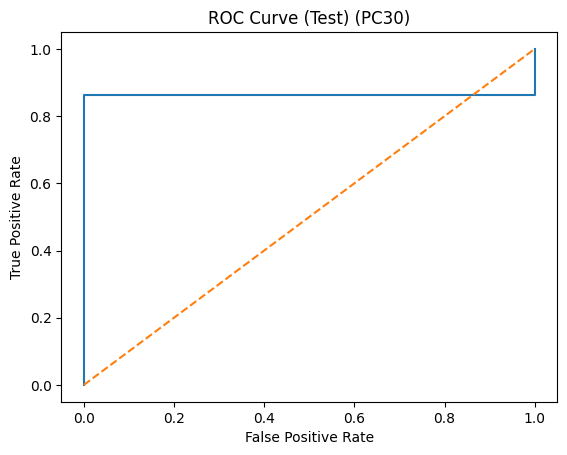

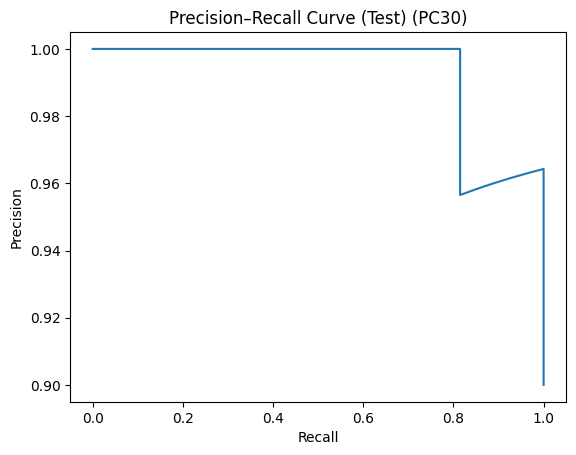

In [ ]:
res30 = run_logreg_no_group(pc30_full, k=30, flag="covid flag")
prec_t, rec_t = res30["probs"]["pr_curve_test"]["precision"], res30["probs"]["pr_curve_test"]["recall"]
fpr_t, tpr_t = res30["probs"]["roc_curve_val"]["fpr"], res30["probs"]["roc_curve_val"]["tpr"]

plt.figure()
plt.plot(fpr_t, tpr_t)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test) (PC30)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure()
plt.plot(rec_t, prec_t)
plt.title("Precision–Recall Curve (Test) (PC30)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
res_sev_30  = run_logreg_multiclass_no_group(pc30_full,  k=30,  flag="covid severity flag")


Patients overlapping across splits fixed: 32
[VAL] Acc=0.600 | Macro AUROC=0.833 | Macro PR-AUC=0.677
[TST] Acc=0.519 | Macro AUROC=0.754 | Macro PR-AUC=0.645
Confusion matrix (rows=true, cols=pred):
 [[2 1 0]
 [4 5 4]
 [1 3 7]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### PC300

Patients overlapping across splits fixed: 27
[VAL] AUROC=0.974 | Acc@0.5=0.939 | PR-AUC=0.997
[TST] AUROC=1.000 | Acc@0.5=0.933 | Acc@thr*=0.833 | PR-AUC=1.000 | thr*=0.747


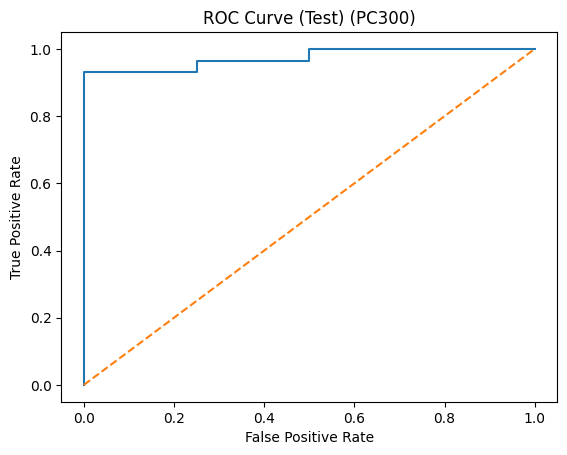

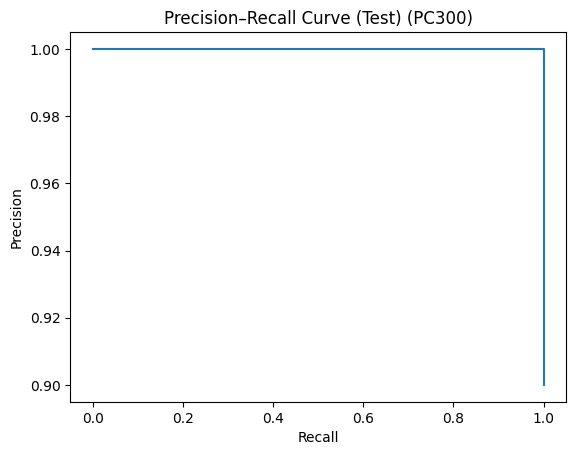

In [ ]:
res300 = run_logreg_no_group(pc300_full, k=300, flag="covid flag")
prec_t, rec_t = res300["probs"]["pr_curve_test"]["precision"], res300["probs"]["pr_curve_test"]["recall"]
fpr_t, tpr_t = res300["probs"]["roc_curve_val"]["fpr"], res300["probs"]["roc_curve_val"]["tpr"]

plt.figure()
plt.plot(fpr_t, tpr_t)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (Test) (PC300)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure()
plt.plot(rec_t, prec_t)
plt.title("Precision–Recall Curve (Test) (PC300)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
res_sev_300  = run_logreg_multiclass_no_group(pc300_full,  k=300,  flag="covid severity flag")


Patients overlapping across splits fixed: 32
[VAL] Acc=0.640 | Macro AUROC=0.747 | Macro PR-AUC=0.575
[TST] Acc=0.630 | Macro AUROC=0.797 | Macro PR-AUC=0.773
Confusion matrix (rows=true, cols=pred):
 [[3 0 0]
 [1 7 5]
 [0 4 7]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
clf = res300["pipe"].named_steps["clf"]
coefs = pd.Series(clf.coef_[0], index=[f"pc{i}" for i in range(1, 301)])
coefs.abs().sort_values(ascending=False).head(10)

,0
pc254,0.589632
pc143,0.573313
pc83,0.537659
pc25,0.536149
pc118,0.523087
pc144,0.490291
pc268,0.484800
pc148,0.472217
pc185,0.461285
pc13,0.452030
